In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import FewShotChatMessagePromptTemplate
from langchain_openai import ChatOpenAI
import os

from sklearn.metrics import root_mean_squared_error 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import neptune

from dotenv import load_dotenv

load_dotenv()

True

# Example

In [8]:
prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
model = ChatOpenAI(model="gpt-3.5-turbo-0125", openai_api_key=os.getenv('OPENAI_API_KEY'))
output_parser = StrOutputParser()

chain = prompt | model | output_parser

chain.invoke({"topic": "bread"})

'Why did the bread go to the doctor? Because it was feeling crumby!'

# Parameters

In [9]:
post_type = 'post_travel' # 'post_travel' or 'post_abortion'
narcism_type = 'adm' # 'riv' or 'adm'
# model chosen from https://platform.openai.com/docs/models/continuous-model-upgrades
model_used = 'gpt-3.5-turbo-0125' # 'gpt-3.5-turbo-0125', 'gpt-4-1106-preview' or 'gpt-4-turbo-2024-04-09'
iterations = 10
number_of_shots = 5 # somewhere between 3 and 10
model_role = "You are a psychologist and you are assessing a patient's Narcissism. The patient is talking about their recent travel. Return only float number between 1 and 6."
train_path = "../data/split/train.csv"
validate_path = "../data/split/validate.csv"

# Code

Here we used the most basic implementation, there is also option to use Dynamic few-shot prompting, but to my knowledge is not needed is this context as we have only one type of posts.

In [10]:
# Get split data using pandas
df = pd.read_csv(train_path)

# Get the dictionary of the first x posts
example = df[[post_type,narcism_type]].iloc[0:number_of_shots]

example = example.to_dict(orient='records')

# Change the value name
for i in range(len(example)):
    example[i]['post'] = example[i].pop(post_type)
    example[i]['narcissism'] = example[i].pop(narcism_type)

example

[{'post': 'I wish I could travel 24/7 and get paid for it',
  'narcissism': 1.444},
 {'post': "Vacations are pricey these days but so worth it! I had the most amazing weekend at ABC resort. Everything about this place screams relaxation and luxury. I'm definitely going back next year. Would you like to come with me?",
  'narcissism': 3.889},
 {'post': 'I recently visited beautiful Stratford upon Avon as a pit-stop on my way to Minehead, Somerset. I made a point to leave my immediate surroundings and find the birthplace of Shakespeare. I found it interesting but ultimately over-commercialised.',
  'narcissism': 3.444},
 {'post': "I have just visited Marrakesh.The scenery is like being in Mars.The soil is do red and there's not a person around for miles. Then you will come across a shepherd all alone with his flock. It makes you wonder how he gets food.The transport there is mainly donkey and cart.",
  'narcissism': 3.667},
 {'post': "I travel a lot for work, and I get to see all sorts o

In [11]:
model = ChatOpenAI(model=model_used, openai_api_key=os.getenv('OPENAI_API_KEY'))


In [12]:
# This is a prompt template used to format each example.
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{post}"),
        ("ai", "result: {narcissism}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=example,
)

# print(few_shot_prompt.format())

#### Use train and validate dataset!!!

In [13]:
test = df[[post_type,narcism_type]].iloc[4] # Test on train dataset
input = test.iloc[0]
input

"I travel a lot for work, and I get to see all sorts of cool places. I didn't think the American south had as many hidden gems as it did, I think it's a beautiful region with some crazy cool people."

In [14]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Return a narcissism number between 1 and 6."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

final_prompt

ChatPromptTemplate(input_variables=['input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='Return a narcissism number between 1 and 6.')), FewShotChatMessagePromptTemplate(examples=[{'post': 'I wish I could travel 24/7 and get paid for it', 'narcissism': 1.444}, {'post': "Vacations are pricey these days but so worth it! I had the most amazing weekend at ABC resort. Everything about this place screams relaxation and luxury. I'm definitely going back next year. Would you like to come with me?", 'narcissism': 3.889}, {'post': 'I recently visited beautiful Stratford upon Avon as a pit-stop on my way to Minehead, Somerset. I made a point to leave my immediate surroundings and find the birthplace of Shakespeare. I found it interesting but ultimately over-commercialised.', 'narcissism': 3.444}, {'post': "I have just visited Marrakesh.The scenery is like being in Mars.The soil is do red and there's not a person around for miles. Then you will come a

In [15]:
chain = final_prompt | model

ai_message = chain.invoke({"input": input})

ai_message


AIMessage(content='result: 1.778', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 356, 'total_tokens': 362, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3bbe151a-2aec-4c23-ac0f-dab2e32ad529-0')

# Analyze the results

In [16]:
r = ai_message.content
match = re.search(r'\d+\.\d+', r)
if match:
    response = float(match.group())
else:
    response = None
response

1.778

In [17]:
test.iloc[1]

1.222

In [18]:
y_pred = []
y_true = []
y_pred.append(response)
y_true.append(test.iloc[1])

In [19]:
mse = root_mean_squared_error(y_true=y_true, y_pred=y_pred)
mse

0.556

# Implementation

In [20]:
# functions

# get random x posts
def get_random_x_posts(path, post_type, narcism_type, number_of_posts):

    df = pd.read_csv(path)
    example = df[[post_type,narcism_type]].sample(number_of_posts)
    example = example.to_dict(orient='records')

    # Change the value name
    for i in range(len(example)):
        example[i]['post'] = example[i].pop(post_type)
        example[i]['narcissism'] = example[i].pop(narcism_type)

    return example

# create a few shot prompt
def create_few_shot_prompt(example):
    example_prompt = ChatPromptTemplate.from_messages(
        [
            ("human", "{post}"),
            ("ai", "narcissism: {narcissism}"),
        ]
    )
    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt,
        examples=example,
    )
    return few_shot_prompt

# create a final prompt
def create_final_prompt(few_shot_prompt,model_role):
    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", model_role),
            few_shot_prompt,
            ("human", "{input}"),
        ]
    )
    return final_prompt

# get float number from a string
def get_float(text):
    # Use regular expression to find numerical value
    match = re.search(r'\d+\.\d+', text)
    if match:
        float_number = float(match.group())
        if float_number is not None:
            return float_number
        else:
            print(f"Wrong input: {text}")
    else:
        return None

# get the response
def get_response(final_prompt, model, input):
    chain = final_prompt | model
    ai_message = chain.invoke({"input": input})
    response = ai_message.content
    return response

# get the mean squared error
def get_rmse(y_pred, y_true):
    rmse = root_mean_squared_error(y_true=y_true, y_pred=y_pred)
    return mse

Add Neptune experiment observation

In [21]:
# Run the functions
run = neptune.init_run(project = os.getenv('NEPTUNE_PROJECT'),
                       api_token = os.getenv('NEPTUNE_API_TOKEN'),
                       source_files=["few_shot_test.ipynb"],
                       tags=["few-shot", narcism_type, post_type])

run["type"] = "Few-shot learning"
params = {
    "model": model_used,
    "narc_type": narcism_type,
    "post_type": post_type,
    "prompt": model_role,
    "shots": number_of_shots
}
run["model/parameters"] = params # Save the parameters

y_pred = []
y_true = []

test_df = pd.read_csv(validate_path)
testset = test_df[[post_type,narcism_type]]

problems = []

for i in range(test.shape[0]):
    example = get_random_x_posts(train_path, post_type, narcism_type, number_of_shots) # Get some random examples
    few_shot_prompt = create_few_shot_prompt(example) 
    #input_dic = get_random_x_posts(validate_path, post_type, narcism_type, 1)
    #input = input_dic.pop(0)
    input = testset.iloc[i]
    final_prompt = create_final_prompt(few_shot_prompt,model_role)
    response_str = get_response(final_prompt, model, input.get(post_type))
    response = get_float(response_str)

    if response is not None: # Check if the model returned a number
        y_pred.append(response)
        y_true.append(input.get(narcism_type))
    else: # Else save the prompt that caused the error
        row_to_add = {'post': input.get(post_type), 'post_type': post_type, 'model_role': model_role, 'date': pd.Timestamp.now()}
        problems.append(row_to_add)


rmse = get_rmse(y_pred, y_true) # Calculate the mean squared error
print(rmse) 
run["rmse"] = rmse
run.stop() # Stop the run

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/NarcisissticTwitter/Twitter/e/TWIT-699
0.556
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/NarcisissticTwitter/Twitter/e/TWIT-699/metadata


In [22]:
# Make a dataframe of the problems
problems_df = pd.DataFrame(problems)
problems_df.to_csv("../data/responses/few_shot.csv", mode='a', index=False, header=False)

problems

[]

# Results

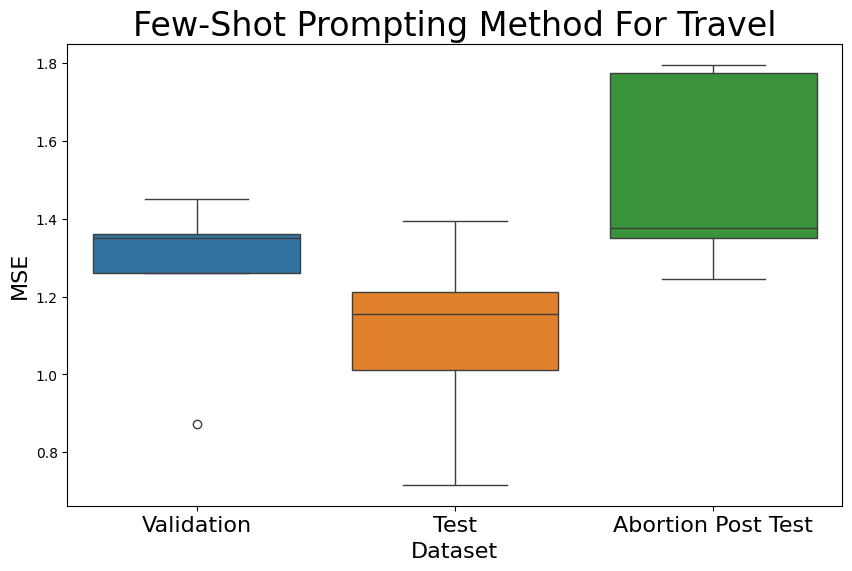

In [23]:
# Data from the provided results (from Neptune)
data = {
    'Val/MSE': [0.873661, 1.351418, 1.450036, 1.261327, 1.360076],
    'Test/MSE': [1.394292, 1.211501, 1.154834, 1.010549, 0.716525],
    'Second_Test/MSE': [1.350694, 1.775061, 1.376452, 1.795675, 1.243888]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Few-Shot Prompting Method For Travel',fontsize=24)
plt.ylabel('MSE',fontsize=16)
plt.xlabel('Dataset',fontsize=16)
plt.xticks(ticks=range(3), labels=['Validation', 'Test', 'Abortion Post Test'],fontsize=16)
plt.show()